# Imports

In [ ]:
import networkx as nx
%matplotlib inline
import numpy as np
import random
import matplotlib
print(nx.__version__)
import matplotlib.pyplot as plt
import math

2.6.3


# Exponential Network

In [ ]:
def exp_graph(n, m, seed):
  random.seed = seed
  G = nx.Graph()
  for i in range(n):
    if i == 0:
      G.add_node(0)
    elif i < m:
        G.add_edge(i,i-1)
    else: # random attachment
      connections = random.sample(range(0, i), m)
      for node in connections:
        G.add_edge(i, node)
  
  return G


# Model


In [ ]:
seed = 42
max_distance = 5
random.seed = seed

class Model:
  def __init__(self, Z, avg_degree, model_name):
    ''' Model properties '''
    self.avg_degree = avg_degree
    self.Z = Z
    self.model_name = model_name
    
    ''' Create Model '''
    if(model_name == 'BA'):
      self.G = nx.barabasi_albert_graph(self.Z, self.avg_degree, seed = seed)
    elif(model_name == 'Exp'):
      self.G = exp_graph(self.Z, self.avg_degree, seed = seed)
    elif(model_name == 'HoSW'):
      self.G = nx.connected_watts_strogatz_graph(self.Z, self.avg_degree, 0.1, tries= 100, seed = seed)
    elif(model_name == 'HeSW'):
      self.G = nx.connected_watts_strogatz_graph(self.Z, self.avg_degree, 1, tries= 100, seed = seed)
    
    self.G.graph['name']=self.model_name

    self.delta = []
    self.eps = []
    for i in range(max_distance):
      self.delta.append(0)
      self.eps.append(0)

    self.t = 1
    self.j = 1

    self.influenced = set()

  def mark_susceptibles(self):
      for node in list(self.G.nodes()):
          self.G.nodes[node]['influenced'] = 0

  def calculate_propensity(self):
    self.update_average_probabilities()
    self.random_model.update_average_probabilities() 

  def calculate_normalized_propensity(self):
    x = list()
    y = list()
    for i in range(max_distance):
      print('eps ', self.eps[i], ' epsrandom ', self.random_model.eps[i])
      self.delta[i] = (self.eps[i] / self.random_model.eps[i]) - 1
      print('delta_' + str(i+1) + '/ delta_1 = ', self.delta[i] / self.delta[0])
      x.append(self.delta[i] / self.delta[0])  
      y.append(i+1)

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    plt.ylim(-0.6, 1.1)
    ax.bar(y,x)
    ax.grid()
    plt.xlabel("social distance")
    plt.ylabel("delta_n/delta_1")
    plt.show()

  def neighbors_at_distance(self, source, neighbors_list):
    for i in range(max_distance):
      neighbors_list.append(set())
      neighbors_list[i] = set(nx.bfs_tree(self.G, source, depth_limit=i+1))

    for i in range(max_distance - 1, 1, -1):
      neighbors_list[i] = neighbors_list[i].difference(neighbors_list[i-1])

  def update_average_probabilities(self):
    if(self.j == 0):
      print('fin')
      return

    j_source = []
    count = []
    
    for i in range(max_distance):
      j_source.append(0)
      count.append(0)

    for source in list(self.G.nodes()):
        neighbors_list = []
        self.neighbors_at_distance(source,neighbors_list)

        for i in range(max_distance):
          if len(neighbors_list[i]) > 0:
            neig_j = 0
            for neighbor in neighbors_list[i]:
                if self.G.nodes[neighbor]['influenced'] == self.G.nodes[source]['influenced']:
                    neig_j += 1

            j_source[i] = (j_source[i] * count[i] + neig_j / len(neighbors_list[i])) / (count[i] + 1) 
            count[i] += 1
    
    for i in range(max_distance):
        if(count[i] > 0):
          self.eps[i] = (self.eps[i] * (self.t) + j_source[i]) / (self.t + 1)
   
  def colorMap(self, color_map):
    for node in list(self.G.nodes()):
        if self.G.nodes[node]['influenced'] == 0:
            color_map.append('blue')
        elif self.G.nodes[node]['influenced'] == 1:
            color_map.append('red')

  def draw(self):
      color_map = []  
      self.colorMap(color_map)
      nx.draw(self.G, node_color=color_map, with_labels=False)
      plt.show()


# Random Model

In [ ]:
class RandomModel(Model):
  def __init__(self, Z, avg_degree, model_name):
    super().__init__(Z, avg_degree, model_name)
    self.j = 0
    random.seed = 42
    self.mark_susceptibles()

  def mark_susceptibles(self):
    super().mark_susceptibles()
  
  def neighbors_at_distance(self, source, neighbors_list):
    super().neighbors_at_distance(source, neighbors_list)
  
  def update_average_probabilities(self):
    super().update_average_probabilities()

  def calculate_propensity(self):
    super().calculate_propensity()

  def calculate_normalized_propensity(self):
    super().calculate_normalized_propensity()
    
  def mark_influenced(self, j):
    self.mark_susceptibles()
    self.influenced = set()
    self.j = j
    nodes_random = random.sample(list(self.G.nodes()), j)
    for node in nodes_random:
      self.G.nodes[node]['influenced'] = 1
      self.influenced.add(node)

# SIR Model


In [ ]:
class SIRModel(Model):
  def __init__(self, Z, avg_degree, model_name):
    super().__init__(Z, avg_degree, model_name)
    np.random.seed = seed

  def mark_susceptibles(self):
      super().mark_susceptibles()

  def simulate_SIR(self, alpha, beta):
      print(self.model_name)
      print('Diameter: ' + str(nx.diameter(self.G)))
      print('Average Degree: {}'.format(self.G.number_of_edges() /self.G.number_of_nodes()))
      print('Average Path Length: {}'.format(nx.average_shortest_path_length(self.G)))
      
      # 1 . All nodes are marked as susceptibles
      self.mark_susceptibles()
      # 2. One node randomly get infected (value:0 = susceptible; value:1 = infected; value:2 = recovered)
      patient_zero_n = random.choice(list(self.G.nodes()))
      self.G.nodes[patient_zero_n]['influenced'] = 1
      #self.draw()
      # 3. Create random model to calculate epsilon of random distribution of infected
      self.create_random_model()
      # 4. Simulate SIR - stops when there is no infected node
      self.SIR_model(alpha, beta, patient_zero_n)
  
  def SIR_model(self, alpha, beta, n0):

      self.influenced.add(n0)

      while len(self.influenced) != 0:
          infected_list = self.influenced.copy()

          for node in infected_list:
              neighbors = list(self.G.neighbors(node))

              for neighbor in neighbors:

                  # Neighbor gets infected with probability alpha
                  if self.G.nodes[neighbor]['influenced'] == 0 and np.random.uniform() < alpha: 
                      self.influenced.add(neighbor)
                      self.G.nodes[neighbor]['influenced'] = 1
                      #self.random_model.mark_infected(1) 
                      self.j += 1

              # Patient recovers with probability beta       
              if np.random.uniform() < beta:           
                  self.G.nodes[node]['influenced'] = 2
                  #self.random_model.mark_recovered(1)
                  self.influenced.remove(node)
                  self.j -= 1

          self.random_model.mark_influenced(self.j)
          self.calculate_propensity()
          #self.draw()
          #change order below
          self.t+=1
          self.random_model.t+=1 

      self.calculate_normalized_propensity()
      return
  
  def calculate_propensity(self):
    super().calculate_propensity()

  def calculate_normalized_propensity(self):
    super().calculate_normalized_propensity()

  def neighbors_at_distance(self, source, neighbors_list):
    super().neighbors_at_distance(source, neighbors_list)

  def update_average_probabilities(self):
    super().update_average_probabilities()
  
  def create_random_model(self):
    self.random_model = RandomModel(self.Z, self.avg_degree, self.model_name)
    self.random_model.mark_influenced(1)  
      
  def colorMap(self, color_map):
      for node in list(self.G.nodes()):
          if self.G.nodes[node]['influenced'] == 0:
              color_map.append('blue')
          elif self.G.nodes[node]['influenced'] == 1:
              color_map.append('red')
          else: 
              color_map.append('green')
      



# Voter Model

In [ ]:
class VoterModel(Model):
  def __init__(self, Z, avg_degree, model_name):
    super().__init__(Z, avg_degree, model_name)
    self.j = 0

  def simulate_VM(self):
    print('Voter Model / ' + self.model_name)
    print('Diameter: ' + str(nx.diameter(self.G)))
    print('Average Degree: ' + str(self.G.number_of_edges() /self.G.number_of_nodes()))
    print('Average Path Length: {}'.format(nx.average_shortest_path_length(self.G)))

    for i in range(self.Z):
      self.G.nodes[i]['influenced'] = random.choice([0,1])
      if (self.G.nodes[i]['influenced'] == 1):
        self.influenced.add(list(self.G.nodes())[i])
        self.j += 1

    self.create_random_model()
    self.VM()

  def VM(self):
    while(self.t < self.Z and 0 < self.j < self.Z):

      if(self.t % 10 == 0):
        print(str(self.t/self.Z) + '%')
      influenced_copy = self.influenced.copy()

      for node in list(self.G.nodes()):
        neighbor = random.choice(list(self.G.neighbors(node)))
        if(self.G.nodes[neighbor]['influenced'] == 1):
          if(self.G.nodes[node]['influenced'] == 0):
            self.G.nodes[node]['influenced'] = 1
            self.influenced.add(node)
            self.j += 1
        else:
          if(self.G.nodes[node]['influenced'] == 1):
            self.G.nodes[node]['influenced'] = 0
            self.influenced.discard(node)
            self.j -= 1


      self.random_model.mark_influenced(self.j)
      self.calculate_propensity()
      self.t+=1
      self.random_model.t+=1
    self.calculate_normalized_propensity()
    return

  def calculate_propensity(self):
    super().calculate_propensity()

  def calculate_normalized_propensity(self):
    super().calculate_normalized_propensity()

  def neighbors_at_distance(self, source, neighbors_list):
    super().neighbors_at_distance(source, neighbors_list)

  def update_average_probabilities(self):
    super().update_average_probabilities()
  
  def create_random_model(self):
    self.random_model = RandomModel(self.Z, self.avg_degree, self.model_name)
  
  def colorMap(self, color_map):
    super().colorMap(color_map)

# Prisoner's Dilemma Model

In [ ]:
class PDModel(Model):
  def __init__(self, Z, avg_degree, model_name):
    super().__init__(Z, avg_degree, model_name)
    self.j = 0
    np.random.seed = seed

    self.payoff_matrix = [ (1, 1), (-1,2) , 
                           (2,-1), (0, 0) ]

  def simulate_PD(self, beta):
    self.beta = beta

    print('Prisoners Dilemma Model / ' + self.model_name)
    print('Diameter: ' + str(nx.diameter(self.G)))
    print('Average Degree: ' + str(self.G.number_of_edges() /self.G.number_of_nodes()))
    print('Average Path Length: {}'.format(nx.average_shortest_path_length(self.G)))

    for i in range(self.Z):
      self.G.nodes[i]['influenced'] = random.choice([0,1])
      self.G.nodes[i]['fitness'] = 0
      if (self.G.nodes[i]['influenced'] == 1):
        self.influenced.add(list(self.G.nodes())[i])
        self.j += 1

    self.create_random_model()
    self.PD()

  def PD(self):
    while(self.t < self.Z and 0 < self.j < self.Z):

      if(self.t % 10 == 0):
        print(str(self.t*100/self.Z) + '%')
      

      for node in list(self.G.nodes()):
        neighbor = random.choice(list(self.G.neighbors(node)))

        fA = self.G.nodes[node]['fitness']
        fB = self.G.nodes[neighbor]['fitness']
        pA = self.calculate_probability_imitate(fA, fB)
        pB = self.calculate_probability_imitate(fB, fA)
        strategyA = np.random.uniform() < pA # true - cooperate : false - defect
        strategyB = np.random.uniform() < pB

        if(strategyA): # A Strategy - Cooperate
          if(self.G.nodes[neighbor]['influenced'] == 1):
            if(self.G.nodes[node]['influenced'] == 0):
              self.G.nodes[node]['influenced'] = 1
              self.j += 1
          else:
            if(self.G.nodes[node]['influenced'] == 1):
              self.G.nodes[node]['influenced'] = 0
              self.j -= 1
          
          if(strategyB):
            self.G.nodes[node]['fitness'] += self.payoff_matrix[0][0]
            self.G.nodes[node]['fitness'] += self.payoff_matrix[0][1]
          else:
            self.G.nodes[node]['fitness'] += self.payoff_matrix[1][0]
            self.G.nodes[node]['fitness'] += self.payoff_matrix[1][1] 
        
        else: # A Strategy - Defect
          if(strategyB):
            self.G.nodes[node]['fitness'] += self.payoff_matrix[2][0]
            self.G.nodes[node]['fitness'] += self.payoff_matrix[2][1]
          else:
            self.G.nodes[node]['fitness'] += self.payoff_matrix[3][0]
            self.G.nodes[node]['fitness'] += self.payoff_matrix[3][1] 


      self.random_model.mark_influenced(self.j)
      self.calculate_propensity()
      self.t+=1
      self.random_model.t+=1
    self.calculate_normalized_propensity()
    return
  
  def calculate_probability_imitate(self, fitnessA, fitnessB):
    exponent = -self.beta * (fitnessB - fitnessA)
    return pow(1 + pow(math.e, exponent), -1)

  def calculate_propensity(self):
    super().calculate_propensity()

  def calculate_normalized_propensity(self):
    super().calculate_normalized_propensity()

  def neighbors_at_distance(self, source, neighbors_list):
    super().neighbors_at_distance(source, neighbors_list)

  def update_average_probabilities(self):
    super().update_average_probabilities()
  
  def create_random_model(self):
    self.random_model = RandomModel(self.Z, self.avg_degree, self.model_name)
  
  def colorMap(self, color_map):
    super().colorMap(color_map)

# Run

## run SIR

BA
Diameter: 5
Average Degree: 4.975
Average Path Length: 2.95407007007007
fin
fin
eps  0.844302193737725  epsrandom  0.8383469134104602
delta_1/ delta_1 =  1.0
eps  0.8255740206292179  epsrandom  0.8222929098461083
delta_2/ delta_1 =  0.5617148543350399
eps  0.8210682797220661  epsrandom  0.822012323099812
delta_3/ delta_1 =  -0.16167213819615547
eps  0.8153678364228317  epsrandom  0.8212921718889429
delta_4/ delta_1 =  -1.015461633516496


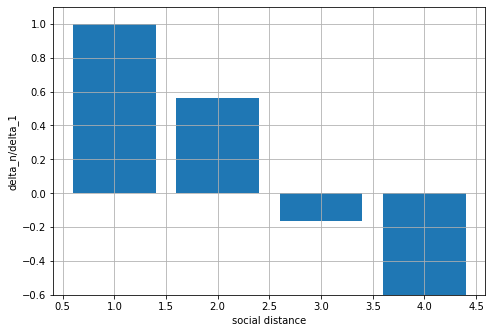

In [ ]:
#model = SIRModel(1000, 2, 'BA')
#model.simulate_SIR(0.5, 0.5)

model = SIRModel(1000, 5, 'BA')
model.simulate_SIR(0.9, 0.2)


HeSW
Diameter: 9
Average Degree: 2.0
Average Path Length: 5.352232232232232
fin
fin
eps  0.8463770720020722  epsrandom  0.837459376734377
delta_1/ delta_1 =  1.0
eps  0.817386546995254  epsrandom  0.8104950357816474
delta_2/ delta_1 =  0.7985005688159532
eps  0.8010802786104344  epsrandom  0.799437213938032
delta_3/ delta_1 =  0.193010714731027
eps  0.7977360859537779  epsrandom  0.7998321325410294
delta_4/ delta_1 =  -0.24610090200704227
eps  0.7957604043357825  epsrandom  0.7996822862219556
delta_5/ delta_1 =  -0.4605620567016406


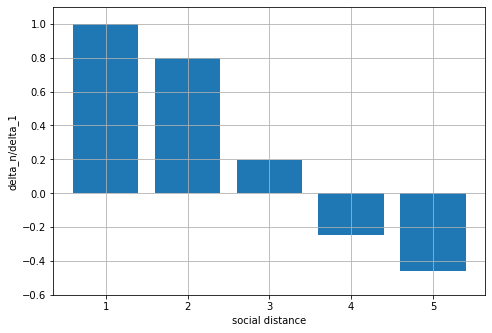

In [ ]:
model = SIRModel(1000, 4, 'HeSW')
model.simulate_SIR(0.9, 0.2)

HoSW
Diameter: 11
Average Degree: 3.0
Average Path Length: 6.206644644644645
fin
fin
eps  0.8768896737213404  epsrandom  0.8626004850088186
delta_1/ delta_1 =  1.0
eps  0.8605088294444986  epsrandom  0.8500228444459506
delta_2/ delta_1 =  0.7446989828109063
eps  0.8438783463406183  epsrandom  0.8425798482663567
delta_3/ delta_1 =  0.09303200224909151
eps  0.8424574658038365  epsrandom  0.8422809443058308
delta_4/ delta_1 =  0.012651521419610063
eps  0.8388057287943281  epsrandom  0.8425291847635081
delta_5/ delta_1 =  -0.2667862209006473


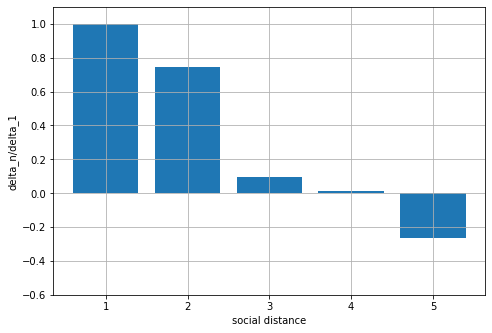

In [ ]:
model = SIRModel(1000, 7, 'HoSW')
model.simulate_SIR(1, 0.2)

Exp
Diameter: 9
Average Degree: 1.997
Average Path Length: 4.935895895895896
fin
fin
eps  0.8611439859523193  epsrandom  0.8530482370888003
delta_1/ delta_1 =  1.0
eps  0.8326751116287192  epsrandom  0.8255902670025785
delta_2/ delta_1 =  0.9042371136244645
eps  0.8186801864846225  epsrandom  0.8154971172937794
delta_3/ delta_1 =  0.4112824813982649
eps  0.8156753911957738  epsrandom  0.815866441759209
delta_4/ delta_1 =  -0.024674355350483172
eps  0.8128612248348982  epsrandom  0.816801114748566
delta_5/ delta_1 =  -0.5082581222323297


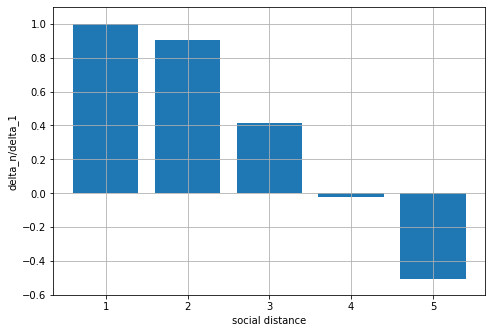

In [ ]:
model = SIRModel(1000, 2, 'Exp')
model.simulate_SIR(1, 0.2)

## run VM

In [ ]:
model = VoterModel(1000, 6, 'HeSW')
model.simulate_VM()

Voter Model / BA
Diameter: 7
Average Degree: 1.996
Average Path Length: 4.0488888888888885
0.01%
0.02%
0.03%
0.04%
0.05%
0.06%
0.07%
0.08%
0.09%
0.1%
0.11%
0.12%
0.13%
eps  0.8605686426180242  epsrandom  0.7509596969623514
delta_1/ delta_1 =  1.0
eps  0.736563394236327  epsrandom  0.6814890765035341
delta_2/ delta_1 =  0.5536825752052028
eps  0.6718987993491725  epsrandom  0.6668618382475092
delta_3/ delta_1 =  0.0517491667290091
eps  0.6641127715724489  epsrandom  0.6668077871061968
delta_4/ delta_1 =  -0.027690528144475073
eps  0.6639010370478438  epsrandom  0.6662384337920677
delta_5/ delta_1 =  -0.024036619110917513


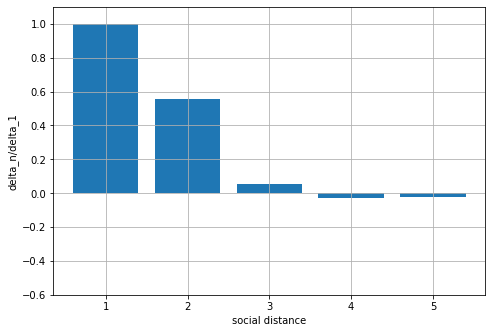

In [ ]:
model = VoterModel(1000, 2, 'BA')
model.simulate_VM()

Voter Model / BA
Diameter: 5
Average Degree: 1.96
Average Path Length: 2.8527272727272726
0.1%
0.2%
eps  0.8051112164412167  epsrandom  0.6990457000057
delta_1/ delta_1 =  1.0
eps  0.6650646612764579  epsrandom  0.6152897493434076
delta_2/ delta_1 =  0.5331656703744861
eps  0.5825727856317613  epsrandom  0.5973661188296763
delta_3/ delta_1 =  -0.16321377511799523
eps  0.5716687452165297  epsrandom  0.5953272559983378
delta_4/ delta_1 =  -0.2619165823636813
eps  0.5593472222222222  epsrandom  0.6083472222222224
delta_5/ delta_1 =  -0.5308549952970842


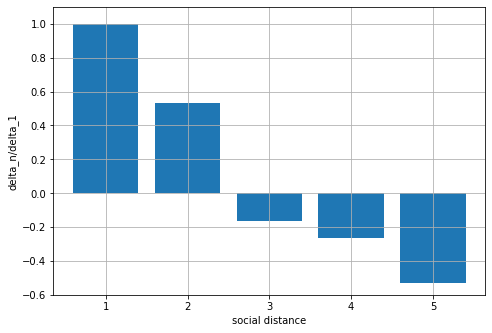

In [ ]:
model = VoterModel(100, 2, 'BA')
model.simulate_VM()

Voter Model / Exp
Diameter: 8
Average Degree: 1.997
Average Path Length: 4.924144144144144
0.01%
0.02%
0.03%
0.04%
0.05%
0.06%
0.07%
0.08%
0.09%
0.1%
0.11%
0.12%
0.13%
0.14%
0.15%
0.16%
0.17%
0.18%
0.19%
0.2%
0.21%
0.22%
0.23%
0.24%
0.25%
0.26%
0.27%
0.28%
0.29%
0.3%
0.31%
eps  0.8491880098868878  epsrandom  0.7378250888871145
delta_1/ delta_1 =  1.0
eps  0.7414722683488404  epsrandom  0.6772675856755233
delta_2/ delta_1 =  0.6280861521591617
eps  0.6696888297429207  epsrandom  0.6567097143974596
delta_3/ delta_1 =  0.13094365419113413
eps  0.6594411761728026  epsrandom  0.6569755196422618
delta_4/ delta_1 =  0.024865442749222793
eps  0.6552952619755203  epsrandom  0.6572662093398647
delta_5/ delta_1 =  -0.019867651159246703


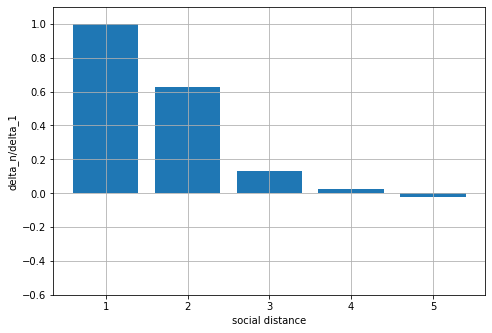

In [ ]:
model = VoterModel(1000, 2, 'Exp')
model.simulate_VM()

In [ ]:
model = VoterModel(1000, 20, 'HoSW')
model.simulate_VM()

Voter Model / HoSW
Diameter: 5
Average Degree: 10.0
Average Path Length: 3.2237077077077076
0.01%
0.02%
0.03%
0.04%
0.05%


## run PD

Prisoners Dilemma Model / BA
Diameter: 5
Average Degree: 1.96
Average Path Length: 2.8527272727272726
0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7%
0.8%
0.9%
eps  0.7750267513492516  epsrandom  0.6376272010347005
delta_1/ delta_1 =  1.0
eps  0.5968672494435668  epsrandom  0.5371717933208789
delta_2/ delta_1 =  0.5157148051128412
eps  0.49897349576510214  epsrandom  0.5160087017458401
delta_3/ delta_1 =  -0.15320462921441677
eps  0.49326395113129046  epsrandom  0.5165587477576783
delta_4/ delta_1 =  -0.2092766269923606
eps  0.4704479166666669  epsrandom  0.507409722222222
delta_5/ delta_1 =  -0.33804609080986725


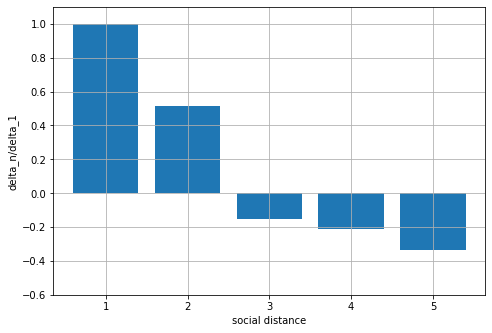

In [ ]:
model = PDModel(1000, 2, 'BA')
model.simulate_PD(0.8)

Prisoners Dilemma Model / HeSW
Diameter: 9
Average Degree: 2.0
Average Path Length: 5.352232232232232
0.01%
0.02%
0.03%
0.04%
0.05%
0.06%
0.07%
0.08%
0.09%
0.1%
0.11%
0.12%
0.13%
0.14%
0.15%
0.16%
0.17%
0.18%
0.19%
0.2%
0.21%
0.22%
0.23%
0.24%
0.25%
0.26%
0.27%
0.28%
0.29%
0.3%
0.31%
0.32%
0.33%
0.34%
0.35%
0.36%
0.37%
0.38%
0.39%
0.4%
0.41%
0.42%
0.43%
0.44%
0.45%
0.46%
0.47%
0.48%
0.49%
0.5%
0.51%
0.52%
0.53%
0.54%
0.55%
0.56%
0.57%
0.58%
0.59%
0.6%
0.61%
0.62%
0.63%
0.64%
0.65%
0.66%
0.67%
0.68%
0.69%
0.7%
0.71%
0.72%
0.73%
0.74%
0.75%
0.76%
0.77%
0.78%
0.79%
0.8%
0.81%
0.82%
0.83%
0.84%
0.85%
0.86%
0.87%
0.88%
0.89%
0.9%
0.91%
0.92%
0.93%
0.94%
0.95%
0.96%
0.97%
0.98%
0.99%
eps  0.7847660278083016  epsrandom  0.642573215537241
delta_1/ delta_1 =  1.0
eps  0.6610105176589296  epsrandom  0.5716078616262001
delta_2/ delta_1 =  0.7068010779261629
eps  0.5662819227111225  epsrandom  0.5448848297013564
delta_3/ delta_1 =  0.17745777537071733
eps  0.5482422575620498  epsrandom  0.54471851

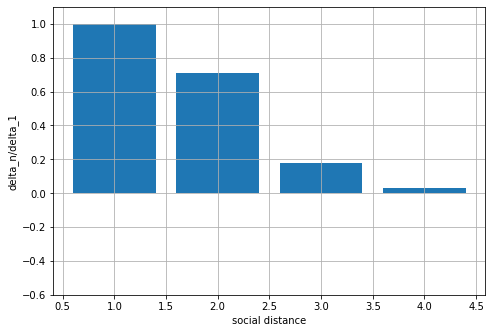

In [ ]:
model = PDModel(1000, 4, 'HeSW')
model.simulate_PD(0.2)

Prisoners Dilemma Model / HoSW
Diameter: 7
Average Degree: 3.0
Average Path Length: 3.6175757575757577
0.1%
0.2%
0.3%
0.4%
0.5%
0.6%
0.7%
0.8%
0.9%
eps  0.8114792857142855  epsrandom  0.5874698809523803
delta_1/ delta_1 =  1.0
eps  0.7033860253750587  epsrandom  0.5503027992450776
delta_2/ delta_1 =  0.7295334972640435
eps  0.5261220699067363  epsrandom  0.5223419668853082
delta_3/ delta_1 =  0.018978770302113562
eps  0.4822232686755978  epsrandom  0.5255321755003993
delta_4/ delta_1 =  -0.216121147411794
eps  0.46310363026528173  epsrandom  0.521380659237105
delta_5/ delta_1 =  -0.293131060746232


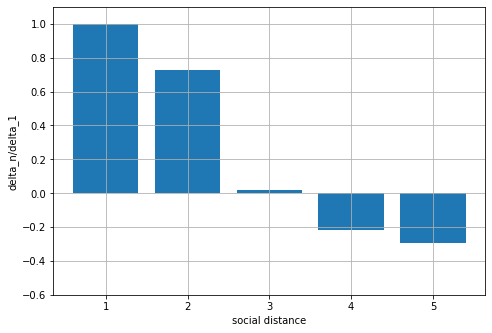

In [ ]:
model = PDModel(100, 6, 'HoSW')
model.simulate_PD(0.8)

Prisoners Dilemma Model / Exp
Diameter: 5
Average Degree: 4.958
Average Path Length: 2.970052104208417
0.02%
0.04%
0.06%
0.08%
0.1%
0.12%
0.14%
0.16%
0.18%
0.2%
0.22%
0.24%
0.26%
0.28%
0.3%
0.32%
0.34%
0.36%
0.38%
0.4%
0.42%
0.44%
0.46%
0.48%
0.5%
0.52%
0.54%
0.56%
0.58%
0.6%
0.62%
0.64%
0.66%
0.68%
0.7%
0.72%
0.74%
fin
fin
eps  0.8045744629676278  epsrandom  0.767774143256945
delta_1/ delta_1 =  1.0
eps  0.753058455303908  epsrandom  0.7435525893640732
delta_2/ delta_1 =  0.2667238707988256
eps  0.7391900107374396  epsrandom  0.7405876666114151
delta_3/ delta_1 =  -0.039373649340886344
eps  0.7347079610882474  epsrandom  0.7405096540063139
delta_4/ delta_1 =  -0.16345789565926108


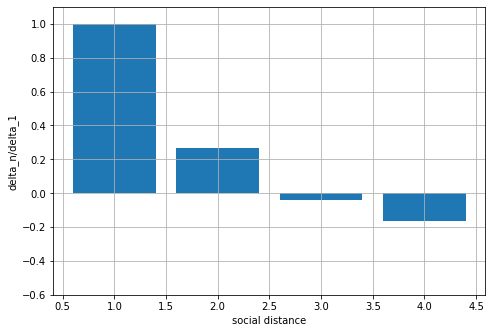

In [ ]:
model = PDModel(500, 5, 'Exp')
model.simulate_PD(0.8)

# Notes 
j -> number of individuals carrying the trait in a population
Z -> population size
n -> distance 

δn(j/Z) -> propensity that 2 individuals at a distance n self-organize in the    same trait relative to a random distribution of traits

ϵn(j/Z) -> the average probability that a node shares the same trait with nodes located at a network distance n

ϵn_rand(j/Z) -> the same quantity associated with a random distribution of traits, given by j/Z

### Stochastic Weight Averaging
new average = average * t + w / t + 1
use for ϵn(j/Z)

